In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import netCDF4 as nc
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.mpl.gridliner 
# import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.mpl.ticker as cticker
import cartopy.io.shapereader as shpreader
from math import sqrt

from matplotlib import colors,cm
import matplotlib as mpl
import cmaps
from matplotlib.colors import ListedColormap 

from scipy.stats import pearsonr
from matplotlib.font_manager import FontProperties

file = './dataset/RH.nc'
dataset = nc.Dataset(file)
# print(dataset.variables.keys())

longitude, latitude = dataset.variables['lon'],dataset.variables['lat']
time = dataset.variables['time']
level =dataset.variables['level']
rhum = dataset.variables['rhum']

cor_num = pd.read_excel(io = r'./dataset/SI0922.xlsx')
coordinate = cor_num['5AV.SI'].tolist()

In [20]:
def num_month_12toNext4(a):
    num_months = (a - 1948) * 12 
    start = num_months - 1
    end = start + 5
    if start <= 0:
        return print("Out Break!")
    else:
        return start, end

def MeanYear(year):
    ls_mean_year = []
    start_month, end_month = num_month_12toNext4(year)
    for i in range(start_month, end_month):
        sum_month_year =  np.zeros(rhum[:1,3:4].data[0][:,:].shape, dtype=float, order='C')
        tmp_pre = rhum[i:i+1,3:4].data[0][:,:]
        sum_month_year += tmp_pre
    mean_year = sum_month_year / 5
    ls_mean_year.append(mean_year[0])
    ls_mean_year = np.array(ls_mean_year)
#     reshape_mean = ls_mean_year.transpose(1,2,0)
    return ls_mean_year

def MeanPhase(startYear, endYear):
    numYear = endYear-startYear
    Mean = np.zeros((numYear, latitude.shape[0], longitude.shape[0]),
                          dtype=float, order='C')
    for year in range(startYear, endYear):
        tmp_mean_each_year = MeanYear(year)
        Mean[year-endYear] = tmp_mean_each_year
    return Mean




Mean1980to2004 = MeanPhase(1982, 2005)
Mean2005to2023 = MeanPhase(2011, 2022)

In [18]:
Mean1980to2004.shape

(23, 73, 144)

In [21]:
Mean2005to2023.shape

(11, 73, 144)

In [22]:
 #对数据进行转置
reshape_mean_1980to2004 = Mean1980to2004.transpose(1,2,0)
reshape_mean_2005to2023 = Mean2005to2023.transpose(1,2,0)

def PearsonMatrix(reshape_mean):
    pearson_matrix = np.zeros((73,144), dtype=float, order='C')
    p_value = np.zeros((73,144), dtype=float, order='C')
    for i in range(len(reshape_mean)):
        for j in range(len(reshape_mean[i])):
            x = reshape_mean[i][j]
            if len(x) == 25:
                y = coordinate[:25]
            elif len(x) == 19:
                y = coordinate[25:]
            elif len(x) == 23:
                y = coordinate[2:25]
            elif len(x) == 11:
                y = coordinate[29:40]
            else:
                print("Error, the dimension x and y ")
            tmp_correlation, _ = pearsonr(x, y)
    #         print(tmp_correlation)
            pearson_matrix[i][j] = tmp_correlation
            p_value[i][j] = _
    pearson_matrix = np.nan_to_num(pearson_matrix)
    return pearson_matrix, p_value

pearson_matrix_1980to2004, p_value_1980to2004 = PearsonMatrix(reshape_mean_1980to2004)
pearson_matrix_2005to2023, p_value_2005to2023 = PearsonMatrix(reshape_mean_2005to2023)

In [23]:
print(pearson_matrix_1980to2004.max(), pearson_matrix_1980to2004.min())
print(pearson_matrix_2005to2023.max(), pearson_matrix_2005to2023.min())

0.7010853799056572 -0.6969109450537871
0.8931669209866567 -0.9374004337695965


In [24]:
print(p_value_1980to2004.max(), p_value_1980to2004.min())
print(p_value_2005to2023.max(), p_value_2005to2023.min())

nan nan
nan nan


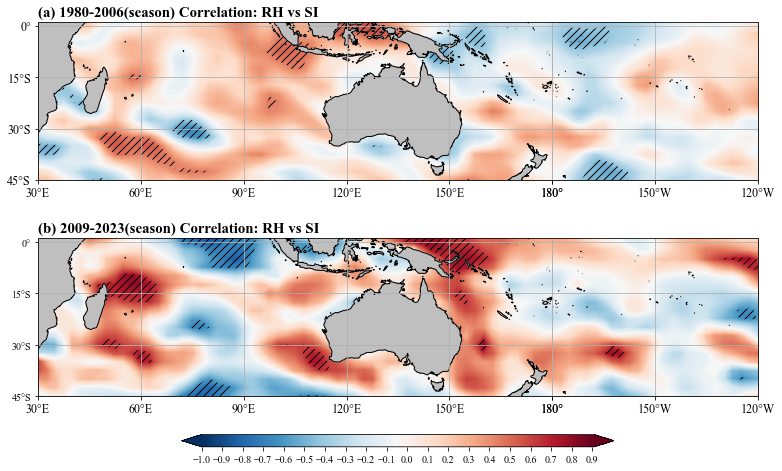

In [26]:
plt.rc('font',family='Times New Roman') 
lon = np.append(longitude[:].data, [360.0])
lat = latitude[:].data

MAX = 0.91
MIN = -1.0

data_phase1 = pearson_matrix_1980to2004 
data_phase2 = pearson_matrix_2005to2023
pvalue1 = p_value_1980to2004
pvalue2 = p_value_2005to2023

# 调整经纬度 向东偏移180
new_data_1980to2004 =[]
for i in range(data_phase1.shape[0]):
    tmp = np.append(data_phase1[i], data_phase1[i][0])
    new_data_1980to2004.append(tmp.tolist())

#设置填色图投影方式，以及地图边界
proj = ccrs.PlateCarree(central_longitude=180)
leftlon, rightlon, lowerlat, upperlat = (30, 180, -45, 1)
lon_formatter = cticker.LongitudeFormatter()
lat_formatter = cticker.LatitudeFormatter()
#建立画布
fig = plt.figure(figsize=(10,10))
# 添加第一个子图
fig_ax1 = fig.add_axes([0, 0.4, 1, 1], projection = proj)

fig_ax1.contourf(longitude[:].data, lat, pvalue1,
            [np.nanmin(pvalue1), 0.05, np.nanmax(pvalue1)],
#                  [0.2, 0.65, 1],
            hatches=['///', None], colors="none",
            transform = ccrs.PlateCarree())  # 增加斜线

fig_ax1.set_extent([leftlon, rightlon, lowerlat, upperlat], crs=ccrs.PlateCarree())
land = cfeature.NaturalEarthFeature('physical','land','50m',edgecolor='face', facecolor=cfeature.COLORS['land'])
fig_ax1.add_feature(land,facecolor='0.75')
fig_ax1.add_feature(cfeature.COASTLINE.with_scale('50m'))
# 切割图
xticks_list = np.hstack((np.arange(30,180.1,30) , np.arange(-180,-90.1,30)))
fig_ax1.set_xticks(xticks_list, crs=ccrs.PlateCarree())
fig_ax1.set_yticks(np.arange(-45,1,15), crs=ccrs.PlateCarree())
labels = fig_ax1.get_xticklabels() + fig_ax1.get_yticklabels()
[label.set_fontproperties(FontProperties(fname="./font/times.ttf",size=12)) for label in labels]

fig_ax1.grid() # 增加网格

fig_ax1.xaxis.set_major_formatter(lon_formatter)
fig_ax1.yaxis.set_major_formatter(lat_formatter)

fig_ax1.set_title('(a) 1980-2006(season) Correlation: RH vs SI',fontweight='bold',
                  loc='left',fontsize =15)

cont_ax1 = fig_ax1.contourf(lon, lat, new_data_1980to2004, 
                 levels=np.arange(MIN, MAX, 0.01),
                        zorder=0,
                transform=ccrs.PlateCarree(),cmap=plt.cm.RdBu_r)


# ====================子图2======================
# 调整经纬度 向东偏移180
new_data_2005to2023=[]
for i in range(data_phase2.shape[0]):
    tmp = np.append(data_phase2[i], data_phase2[i][0])
    new_data_2005to2023.append(tmp.tolist())

fig_ax2 = fig.add_axes([0, 0.1, 1, 1], projection = proj)

fig_ax2.contourf(longitude[:].data, lat, pvalue2,
            [np.nanmin(pvalue2), 0.05, np.nanmax(pvalue2)],
#                  [0.3, 0.35, np.nanmax(pvalue2)],
            hatches=['///', None], colors="none",
            transform = ccrs.PlateCarree())  # 增加斜线

fig_ax2.set_extent([leftlon, rightlon, lowerlat, upperlat], crs=ccrs.PlateCarree())
land = cfeature.NaturalEarthFeature('physical','land','50m',edgecolor='face', facecolor=cfeature.COLORS['land'])
fig_ax2.add_feature(land,facecolor='0.75')
fig_ax2.add_feature(cfeature.COASTLINE.with_scale('50m'))
fig_ax2.set_xticks(xticks_list, crs=ccrs.PlateCarree())
fig_ax2.set_yticks(np.arange(-45,1,15), crs=ccrs.PlateCarree())
labels = fig_ax2.get_xticklabels() + fig_ax1.get_yticklabels()
[label.set_fontproperties(FontProperties(fname="./font/times.ttf",size=12)) for label in labels]

fig_ax2.grid() # 增加网格

fig_ax2.xaxis.set_major_formatter(lon_formatter)
fig_ax2.yaxis.set_major_formatter(lat_formatter)

fig_ax2.set_title('(b) 2009-2023(season) Correlation: RH vs SI',fontweight='bold',
                  loc='left',fontsize =15)
cont_ax2 = fig_ax2.contourf(lon, lat, new_data_2005to2023, 
                 levels=np.arange(MIN, MAX, 0.01),
                        zorder=0,
                transform=ccrs.PlateCarree(),cmap=plt.cm.RdBu_r)

font = {'family' : 'Times New Roman',
        'weight' : 'normal',
        'size'   : 16,
        }

norm = colors.Normalize(vmin=MIN, vmax=MAX)    #确定colormap的最大最小值

position = fig.add_axes([0.2, 0.42, 0.6, 0.017]) # 最下面位置

# c1 = fig_ax2.contourf(lon_pacific_1998to2021, lat, data_1998to2021, levels=np.arange(-0.9,1.0,0.1), zorder=0, extend = 'both', transform=ccrs.PlateCarree(), cmap=plt.cm.RdBu_r)

fc2=fig.colorbar(
                mpl.cm.ScalarMappable(norm=norm,cmap=plt.cm.RdBu_r),
#                 c1,
                 cax=position,
                 orientation='horizontal',
                 ticks=np.arange(MIN, MAX, 0.1).tolist(),                                                    
                 extend='both',
                fraction=0.012) 

fc2.set_label(label="", fontdict=font) #设置colorbar的标签字体及其大小


plt.savefig("rh_correl_12toNext4.png",dpi=300,bbox_inches='tight')

plt.show()